In [1]:
!pip install -q evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
import nltk
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# Download nltk tokenizer
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')


2026-01-15 17:57:06.185027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768499826.359157      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768499826.407982      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768499826.832701      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768499826.832743      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768499826.832745      55 computation_placer.cc:177] computation placer alr

In [3]:
# ==============================================================================
# 1. CONFIGURATION & PATHS
# ==============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Running on device: {device}")

# DATASET PATHS (Matching your previous request)
DATASET_DIR = '/kaggle/input/vqarad'
IMAGE_DIR = os.path.join(DATASET_DIR, 'VQA_RAD Image Folder')
TRAIN_CSV = os.path.join(DATASET_DIR, 'vqa_rad_train.csv')
TEST_CSV = os.path.join(DATASET_DIR, 'vqa_rad_test.csv')

# ==============================================================================
# 2. DATA PREPROCESSING
# ==============================================================================
print("🔄 Loading CSVs...")
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Helper: Clean Text
def preprocess_text(text):
    if not isinstance(text, str): return str(text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Remove special chars
    return " ".join(text.split())

# Apply cleaning
for df in [train_df, test_df]:
    df['clean_question'] = df['question'].apply(preprocess_text)
    df['clean_answer'] = df['answer'].apply(preprocess_text)
    df['img_id'] = df['img_id'].astype(str) # Ensure Image IDs are strings
    
    # Handle Answer Type (Closed vs Open)
    if 'answer_type' in df.columns:
        df['type_norm'] = df['answer_type'].astype(str).str.upper()
    else:
        # Infer type if column missing
        df['type_norm'] = df['clean_answer'].apply(lambda x: 'CLOSED' if x in ['yes', 'no'] else 'OPEN')

print(f"Dataset Sizes: Train({len(train_df)}), Test({len(test_df)})")


✅ Running on device: cuda
🔄 Loading CSVs...
Dataset Sizes: Train(1797), Test(225)


In [4]:
# ==============================================================================
# 3. BUILD VOCABULARY & ANSWER MAPPING
# ==============================================================================
class Vocabulary:
    def __init__(self, freq_threshold=1):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in nltk.word_tokenize(sentence.lower()):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = nltk.word_tokenize(text.lower())
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]

# 1. Build Question Vocabulary (Train only is standard, but Train+Test prevents UNKs)
vocab = Vocabulary(freq_threshold=1)
vocab.build_vocabulary(train_df['clean_question'].tolist() + test_df['clean_question'].tolist())
vocab_size = len(vocab.itos)

# 2. Build Answer Mapping (Classes)
# IMPORTANT: Combine answers from Train and Test to ensure the model knows all possible classes
all_answers = pd.concat([train_df['clean_answer'], test_df['clean_answer']])
unique_answers = sorted(all_answers.unique())
answer_map = {label: idx for idx, label in enumerate(unique_answers)}
idx2ans = {v: k for k, v in answer_map.items()} # Reverse map for checking results
num_classes = len(answer_map)

print(f"Vocab Size: {vocab_size} | Num Classes: {num_classes}")


Vocab Size: 1146 | Num Classes: 463


In [5]:
# ==============================================================================
# 4. DATASET CLASS
# ==============================================================================
class HybridVQADataset(Dataset):
    def __init__(self, df, img_dir, vocab, answer_map, transform=None, max_len=20):
        self.df = df
        self.img_dir = img_dir
        self.vocab = vocab
        self.answer_map = answer_map
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['img_id']
        
        # Image Loading (Handle missing extensions)
        img_path = os.path.join(self.img_dir, img_id)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224)) # Black placeholder
            
        if self.transform: image = self.transform(image)
        
        # Question Tokenization
        q_indices = [self.vocab.stoi["<SOS>"]] + self.vocab.numericalize(row['clean_question']) + [self.vocab.stoi["<EOS>"]]
        if len(q_indices) < self.max_len:
            q_indices += [self.vocab.stoi["<PAD>"]] * (self.max_len - len(q_indices))
        else:
            q_indices = q_indices[:self.max_len]
            
        # Label Encoding
        label = self.answer_map.get(row['clean_answer'], 0)
        
        return image, torch.tensor(q_indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Transforms
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Loaders
train_loader = DataLoader(HybridVQADataset(train_df, IMAGE_DIR, vocab, answer_map, tfm), batch_size=32, shuffle=True)
test_loader = DataLoader(HybridVQADataset(test_df, IMAGE_DIR, vocab, answer_map, tfm), batch_size=32, shuffle=False)



🚀 STARTING TRAINING
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 209MB/s] 


Epoch 1/20 | Train Loss: 4.3488 | Val Loss: 3.5877 | Val Acc: 0.2933
Epoch 2/20 | Train Loss: 3.8250 | Val Loss: 3.6110 | Val Acc: 0.3022
Epoch 3/20 | Train Loss: 3.7278 | Val Loss: 3.7216 | Val Acc: 0.3067
Epoch 4/20 | Train Loss: 3.6533 | Val Loss: 3.6132 | Val Acc: 0.3111
Epoch 5/20 | Train Loss: 3.2195 | Val Loss: 3.2405 | Val Acc: 0.3689
Epoch 6/20 | Train Loss: 2.9084 | Val Loss: 3.3302 | Val Acc: 0.3733
Epoch 7/20 | Train Loss: 2.7425 | Val Loss: 3.3416 | Val Acc: 0.3378
Epoch 8/20 | Train Loss: 2.5518 | Val Loss: 3.7741 | Val Acc: 0.3556
Epoch 9/20 | Train Loss: 2.3363 | Val Loss: 3.8839 | Val Acc: 0.3422
Epoch 10/20 | Train Loss: 2.1465 | Val Loss: 4.3612 | Val Acc: 0.3644
Epoch 11/20 | Train Loss: 1.9913 | Val Loss: 4.6616 | Val Acc: 0.3333
Epoch 12/20 | Train Loss: 1.8321 | Val Loss: 4.3458 | Val Acc: 0.3511
Epoch 13/20 | Train Loss: 1.7403 | Val Loss: 4.5098 | Val Acc: 0.3467
Epoch 14/20 | Train Loss: 1.5734 | Val Loss: 4.9779 | Val Acc: 0.3600
Epoch 15/20 | Train Loss: 1.4

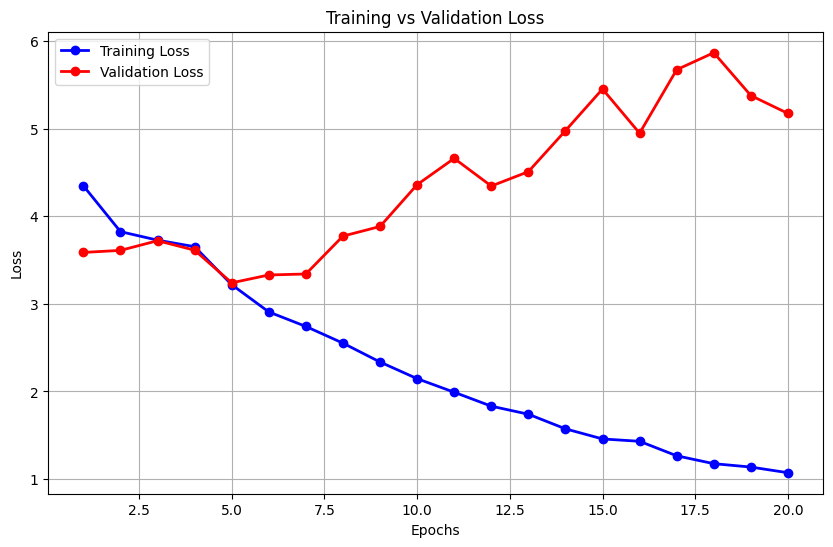

In [6]:
# ==============================================================================
# 5. MODEL ARCHITECTURE (CNN + LSTM + ATTENTION)
# ==============================================================================
class Attention(nn.Module):
    def __init__(self, v_dim, q_dim, num_hid):
        super().__init__()
        self.v_proj = nn.Linear(v_dim, num_hid)
        self.q_proj = nn.Linear(q_dim, num_hid)
        self.linear = nn.Linear(num_hid, 1)

    def forward(self, v, q):
        v_proj = self.v_proj(v) # [Batch, 49, num_hid]
        q_proj = self.q_proj(q).unsqueeze(1) # [Batch, 1, num_hid]
        att_scores = self.linear(torch.tanh(v_proj + q_proj)) # [Batch, 49, 1]
        alpha = F.softmax(att_scores, dim=1)
        return (v * alpha).sum(1) # Context vector [Batch, v_dim]

class Hybrid_CNN_LSTM_Attention(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super().__init__()
        # Visual Encoder (VGG19)
        vgg = models.vgg19(weights='DEFAULT')
        self.cnn = nn.Sequential(*list(vgg.children())[:-1]) 
        
        # Text Encoder
        self.embedding = nn.Embedding(vocab_size, 256)
        self.lstm = nn.LSTM(256, 512, batch_first=True)
        
        # Fusion
        self.attention = Attention(512, 512, 256)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1024), 
            nn.ReLU(), 
            nn.Dropout(0.5), 
            nn.Linear(1024, num_classes)
        )

    def forward(self, images, questions):
        # Image Features [Batch, 512, 7, 7] -> [Batch, 49, 512]
        img_features = self.cnn(images).view(images.size(0), 512, -1).transpose(1, 2)
        
        # Text Features
        _, (hidden, _) = self.lstm(self.embedding(questions))
        text_features = hidden[-1] # [Batch, 512]
        
        # Attention
        weighted_v = self.attention(img_features, text_features)
        
        # Concatenate & Classify
        combined = torch.cat((weighted_v, text_features), dim=1)
        return self.classifier(combined)

# ==============================================================================
# 6. TRAINING LOOP (UPDATED: Calculates Validation Loss)
# ==============================================================================
print("\n🚀 STARTING TRAINING")
model = Hybrid_CNN_LSTM_Attention(vocab_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Lists to store metrics
train_losses = []
val_losses = []  # <--- NEW: List to store validation loss

epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    # --- Training Phase ---
    for imgs, qs, lbls in train_loader:
        imgs, qs, lbls = imgs.to(device), qs.to(device), lbls.to(device)
        optimizer.zero_grad()
        
        outputs = model(imgs, qs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == lbls).sum().item()
        total += lbls.size(0)
    
    epoch_loss = total_loss / total
    epoch_acc = correct / total
    
    # --- Validation Phase ---
    model.eval()
    val_running_loss = 0 # <--- NEW: Track val loss
    val_correct, val_total = 0, 0
    
    with torch.no_grad():
        for imgs, qs, lbls in test_loader:
            imgs, qs, lbls = imgs.to(device), qs.to(device), lbls.to(device)
            outputs = model(imgs, qs)
            
            # Calculate Loss (Validation)
            loss = criterion(outputs, lbls) 
            val_running_loss += loss.item() * imgs.size(0)
            
            val_correct += (outputs.argmax(1) == lbls).sum().item()
            val_total += lbls.size(0)
    
    epoch_val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    
    # Store history
    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
            
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Save Best Model
torch.save(model.state_dict(), "hybrid_model_best.pth")
print("✅ Model Saved.")

# ==============================================================================
# PLOT: TRAINING LOSS VS VALIDATION LOSS
# ==============================================================================
def plot_loss_curves(train_losses, val_losses):
    epochs_range = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))

    # Plotting both curves
    plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss', linewidth=2)
    plt.plot(epochs_range, val_losses, 'r-o', label='Validation Loss', linewidth=2)
    
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Run the plot function
plot_loss_curves(train_losses, val_losses)


📊 RUNNING DETAILED EVALUATION...



>>> OVERALL QUESTIONS (225 samples)
  Accuracy:      34.22%
  Precision (W): 0.3422
  Recall (W):    0.3422
  F1-Score (W):  0.3404
  BLEU-2:        0.0521
  ROUGE-L:       0.3467

>>> CLOSED (Yes/No) QUESTIONS (144 samples)
  Accuracy:      52.78%
  Precision (W): 0.5296
  Recall (W):    0.5278
  F1-Score (W):  0.5264
  BLEU-2:        0.0000
  ROUGE-L:       0.5278

>>> OPEN ENDED QUESTIONS (81 samples)
  Accuracy:      1.23%
  Precision (W): 0.0247
  Recall (W):    0.0123
  F1-Score (W):  0.0165
  BLEU-2:        0.0155
  ROUGE-L:       0.0173

>>> CONFUSION MATRIX (Closed-Ended: Yes vs No)


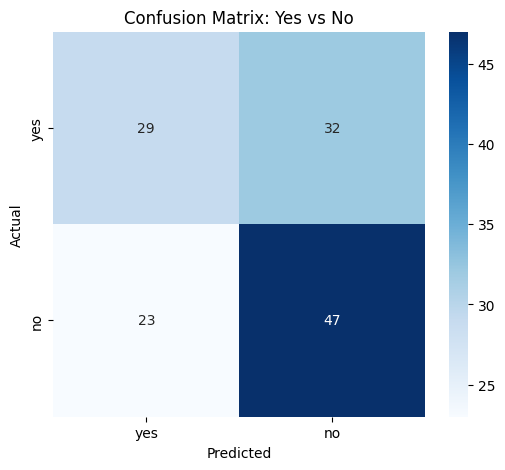

In [ ]:
# ==============================================================================
# 7. EVALUATION & METRICS
# ==============================================================================
print("\n📊 RUNNING DETAILED EVALUATION...")

# Reload metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

model.eval()

# Storage
closed_preds, closed_refs = [], []
open_preds, open_refs = [], []
all_preds, all_refs = [], []

# We need a fresh loader without shuffle to match dataframe order if needed, 
# but here we rely on the loop data directly.
with torch.no_grad():
    for i, (imgs, qs, lbls) in enumerate(test_loader):
        imgs, qs, lbls = imgs.to(device), qs.to(device), lbls.to(device)
        outputs = model(imgs, qs)
        _, preds = torch.max(outputs, 1)
        
        # Convert batch tensors to lists
        preds_list = preds.cpu().numpy()
        lbls_list = lbls.cpu().numpy()
        
        # Get start index for this batch to find answer types in dataframe
        start_idx = i * test_loader.batch_size
        
        for j in range(len(preds_list)):
            pred_text = idx2ans.get(preds_list[j], "")
            ref_text = idx2ans.get(lbls_list[j], "")
            
            # Identify Type from Test DataFrame
            # Note: This assumes DataLoader order matches DataFrame order (True if shuffle=False)
            current_idx = start_idx + j
            if current_idx < len(test_df):
                ans_type = test_df.iloc[current_idx]['type_norm']
            else:
                ans_type = 'OPEN' # Fallback
            
            # Store in All
            all_preds.append(pred_text)
            all_refs.append(ref_text)
            
            # Split by Type
            if ans_type == 'CLOSED':
                closed_preds.append(pred_text)
                closed_refs.append(ref_text)
            else:
                open_preds.append(pred_text)
                open_refs.append(ref_text)

def print_metrics(name, preds, refs):
    if len(preds) == 0: return
    
    print(f"\n>>> {name} QUESTIONS ({len(preds)} samples)")
    
    # Accuracy
    acc = accuracy_score(refs, preds)
    
    # Precision, Recall, F1 (Weighted)
    p, r, f1, _ = precision_recall_fscore_support(refs, preds, average='weighted', zero_division=0)
    
    # BLEU-2
    try:
        b2 = bleu_metric.compute(predictions=preds, references=[[r] for r in refs], max_order=2)['bleu']
    except:
        b2 = 0.0
        
    # ROUGE-L
    r_l = rouge_metric.compute(predictions=preds, references=refs)['rougeL']
    
    print(f"  Accuracy:      {acc*100:.2f}%")
    print(f"  Precision (W): {p:.4f}")
    print(f"  Recall (W):    {r:.4f}")
    print(f"  F1-Score (W):  {f1:.4f}")
    print(f"  BLEU-2:        {b2:.4f}")
    print(f"  ROUGE-L:       {r_l:.4f}")

# Print Reports
print_metrics("OVERALL", all_preds, all_refs)
print_metrics("CLOSED (Yes/No)", closed_preds, closed_refs)
print_metrics("OPEN ENDED", open_preds, open_refs)

# ==============================================================================
# 8. CONFUSION MATRIX (CLOSED ONLY)
# ==============================================================================
print("\n>>> CONFUSION MATRIX (Closed-Ended: Yes vs No)")

# Filter data to only include 'yes' and 'no' labels to keep the plot clean
labels = ['yes', 'no']
filtered_refs = []
filtered_preds = []

for r, p in zip(closed_refs, closed_preds):
    if r in labels and p in labels:
        filtered_refs.append(r)
        filtered_preds.append(p)

if len(filtered_refs) > 0:
    cm = confusion_matrix(filtered_refs, filtered_preds, labels=labels)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix: Yes vs No')
    plt.show()
else:
    print("Not enough Yes/No data for Confusion Matrix.")